In [165]:
data = read.table('./5.metacyc/humann2_final_out/humann2_pathabundance_cpm_unstratified2.tsv',check.names = F,header =T,quote="",sep = '\t')

In [166]:
data = data[-c(1,2),]

In [167]:
dim(data)

[1] 336  33

In [170]:
df <- data %>% separate(Pathway	, c('Name1', 'Name2'),sep = '\\: ')

In [172]:
dim(df)

[1] 336  34

In [173]:
df = df[,-1]

In [178]:
rownames(df) = df[,1]

In [179]:
df = df[,-1]

In [180]:
head(df,2)

,KO-CLP1,KO-CLP2,KO-CLP3,KO-CLP4,KO-CLP5,KO-CLP6,KO-CLP7,KO-CLP8,KO-NC1,KO-NC2,⋯,WT-CLP7,WT-CLP8,WT-NC1,WT-NC2,WT-NC3,WT-NC4,WT-NC5,WT-NC6,WT-NC7,WT-NC8
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
folate transformations III (E. coli),373.09400,257.207,311.685,230.93200,246.13900,255.35900,269.87400,203.0820,191.12600,206.99300,⋯,297.997,292.13400,138.053,195.198,234.83600,212.98800,225.29900,282.8620,221.29500,193.82100
superpathway of allantoin degradation in yeast,2.65824,0.000,0.000,5.72585,3.28336,3.07257,6.12238,4.1333,1.28045,1.55677,⋯,0.000,1.71647,0.000,0.000,1.53196,5.17566,6.18274,3.3258,8.44011,7.49206


In [181]:
group = read.table('./5.metacyc/sample.txt',header = T,sep = '\t')

In [183]:
library(tidyverse)
df <- df*100

In [184]:
df <- df %>% filter(apply(df,1,mean) > 1)

In [185]:
data <- t(df)
data1 <- data.frame(data,group$group)

In [186]:
colnames(data1) <- c(colnames(data),"Group")
data1$Group <- as.factor(data1$Group)

In [189]:
data1$Group

[1] KO-CLP KO-CLP KO-CLP KO-CLP KO-CLP KO-CLP KO-CLP KO-CLP KO-NC  KO-NC 
[11] KO-NC  KO-NC  KO-NC  KO-NC  KO-NC  KO-NC  WT-CLP WT-CLP WT-CLP WT-CLP
[21] WT-CLP WT-CLP WT-CLP WT-CLP WT-NC  WT-NC  WT-NC  WT-NC  WT-NC  WT-NC 
[31] WT-NC  WT-NC 
Levels: KO-CLP KO-NC WT-CLP WT-NC

In [223]:
data1 = data1 %>% filter(Group %in% c('KO-CLP','WT-CLP'))

In [224]:
diff <- data1 %>%
    select_if(is.numeric) %>%
    map_df(~ broom::tidy(t.test(. ~ Group,data = data1)), .id = 'var')

In [225]:
diff$p.value <- p.adjust(diff$p.value,"BH")

In [226]:
diff <- diff %>% filter(p.value < 0.05)

In [227]:
abun.bar <- data1[,c(diff$var,"Group")] %>%
    gather(variable,value,-Group) %>%
    group_by(variable,Group) %>%
    summarise(Mean = mean(value))

`summarise()` has grouped output by 'variable'. You can override using the
`.groups` argument.


In [228]:
diff.mean <- diff[,c("var","estimate","conf.low","conf.high","p.value")]
diff.mean$Group <- c(ifelse(diff.mean$estimate >0,levels(data1$Group)[1],
                            levels(data1$Group)[2]))
diff.mean <- diff.mean[order(diff.mean$estimate,decreasing = TRUE),]

In [229]:
library(ggplot2)
cbbPalette <- c("#E69F00", "#56B4E9")
abun.bar$variable <- factor(abun.bar$variable,levels = rev(diff.mean$var))

In [230]:
p1 <- ggplot(abun.bar,aes(variable,Mean,fill = Group)) +
    scale_x_discrete(limits = levels(diff.mean$var)) +
    coord_flip() +
    xlab("") +
    ylab("Mean proportion (%)") +
    theme(panel.background = element_rect(fill = 'transparent'),
          panel.grid = element_blank(),
          axis.ticks.length = unit(0.4,"lines"),
          axis.ticks = element_line(color='black'),
          axis.line = element_line(colour = "black"),
          axis.title.x=element_text(colour='black', size=12,face = "bold"),
          axis.text=element_text(colour='black',size=10,face = "bold"),
          legend.title=element_blank(),
          legend.text=element_text(size=12,face = "bold",colour = "black",
                                   margin = margin(r = 20)),
          legend.position = c(-1,-0.1),
          legend.direction = "horizontal",
          legend.key.width = unit(0.8,"cm"),
          legend.key.height = unit(0.5,"cm"))
for (i in 1:(nrow(diff.mean) - 1))
    p1 <- p1 + annotate('rect', xmin = i+0.5, xmax = i+1.5, ymin = -Inf, ymax = Inf,
                        fill = ifelse(i %% 2 == 0, 'white', 'gray95'))
 
p1 <- p1 +
    geom_bar(stat = "identity",position = "dodge",width = 0.7,colour = "black") +
    scale_fill_manual(values=cbbPalette)

In [231]:
options(repr.plot.height = 4,repr.plot.width = 12)

In [232]:
abun.bar

variable,Group,Mean
<fct>,<fct>,<dbl>
L-arginine biosynthesis IV (archaebacteria),KO-CLP,16083.9750
L-arginine biosynthesis IV (archaebacteria),WT-CLP,8051.5887
anhydromuropeptides recycling I,KO-CLP,5040.6875
anhydromuropeptides recycling I,WT-CLP,1203.8569
gluconeogenesis III,KO-CLP,2916.5200
gluconeogenesis III,WT-CLP,8217.6663
incomplete reductive TCA cycle,KO-CLP,980.8178
incomplete reductive TCA cycle,WT-CLP,3200.9175
superpathway of L-serine and glycine biosynthesis I,KO-CLP,18462.1500


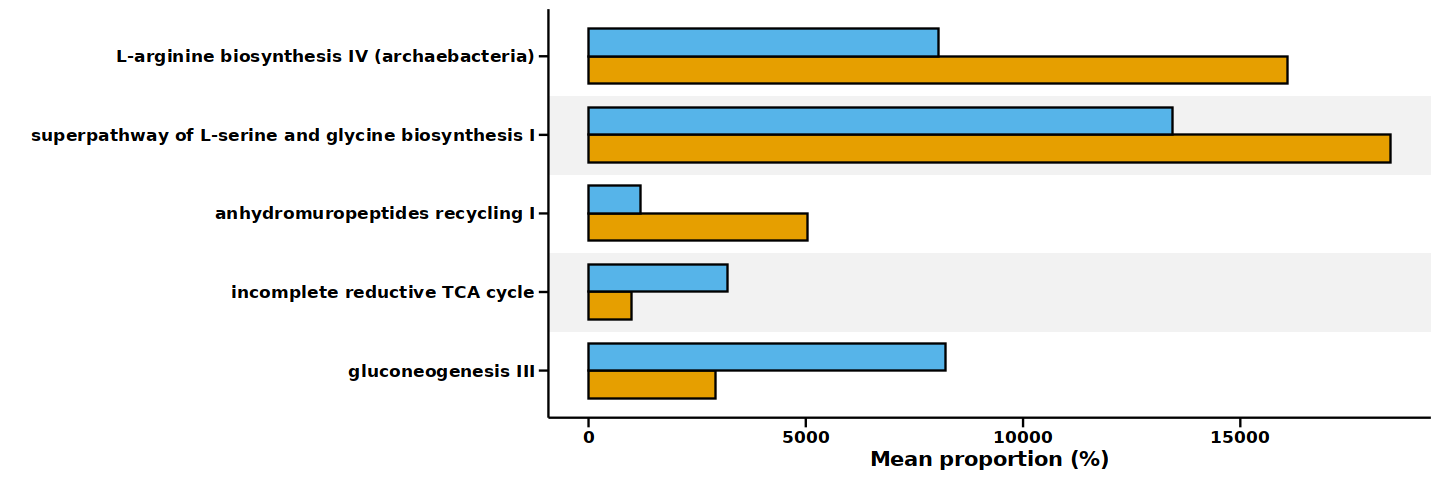

In [233]:
p1

In [234]:
diff.mean$var <- factor(diff.mean$var,levels = levels(abun.bar$variable))
diff.mean$p.value <- signif(diff.mean$p.value,3)
diff.mean$p.value <- as.character(diff.mean$p.value)

In [235]:
p2 <- ggplot(diff.mean,aes(var,estimate,fill = Group)) +
    theme(panel.background = element_rect(fill = 'transparent'),
          panel.grid = element_blank(),
          axis.ticks.length = unit(0.4,"lines"),
          axis.ticks = element_line(color='black'),
          axis.line = element_line(colour = "black"),
          axis.title.x=element_text(colour='black', size=12,face = "bold"),
          axis.text=element_text(colour='black',size=10,face = "bold"),
          axis.text.y = element_blank(),
          legend.position = "none",
          axis.line.y = element_blank(),
          axis.ticks.y = element_blank(),
          plot.title = element_text(size = 15,face = "bold",colour = "black",hjust = 0.5)) +
    scale_x_discrete(limits = levels(diff.mean$var)) +
    coord_flip() +
    xlab("") +
    ylab("Difference in mean proportions (%)") +
    labs(title="95% confidence intervals")
 
for (i in 1:(nrow(diff.mean) - 1))
    p2 <- p2 + annotate('rect', xmin = i+0.5, xmax = i+1.5, ymin = -Inf, ymax = Inf,
                        fill = ifelse(i %% 2 == 0, 'white', 'gray95'))
 
p2 <- p2 +
    geom_errorbar(aes(ymin = conf.low, ymax = conf.high),
                  position = position_dodge(0.8), width = 0.5, size = 0.5) +
    geom_point(shape = 21,size = 3) +
    scale_fill_manual(values=cbbPalette) +
    geom_hline(aes(yintercept = 0), linetype = 'dashed', color = 'black')

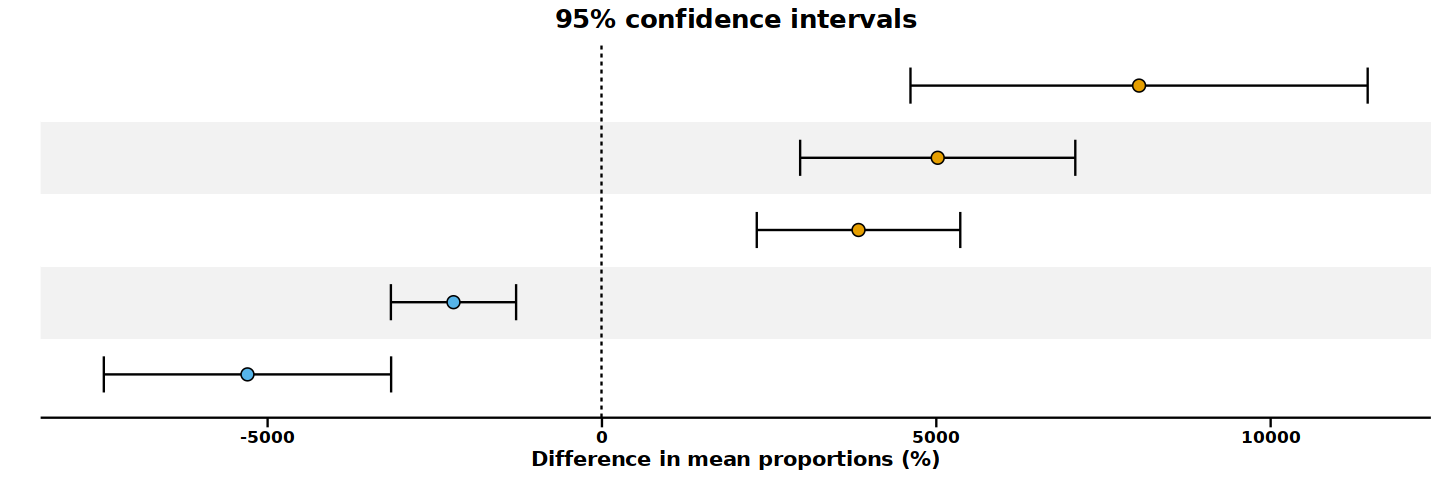

In [236]:
p2

In [237]:
p3 <- ggplot(diff.mean,aes(var,estimate,fill = Group)) +
    geom_text(aes(y = 0,x = var),label = diff.mean$p.value,
              hjust = 0,fontface = "bold",inherit.aes = FALSE,size = 3) +
    geom_text(aes(x = nrow(diff.mean)/2 +0.5,y = 0.85),label = "P-value (corrected)",
             srt = 90,fontface = "bold",size = 5) +
    coord_flip() +
    ylim(c(0,1)) +
    theme(panel.background = element_blank(),
          panel.grid = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          axis.text = element_blank(),
          axis.title = element_blank())

In [238]:
library(patchwork)
p <- p1 + p2 + p3 + plot_layout(widths = c(4,6,2))

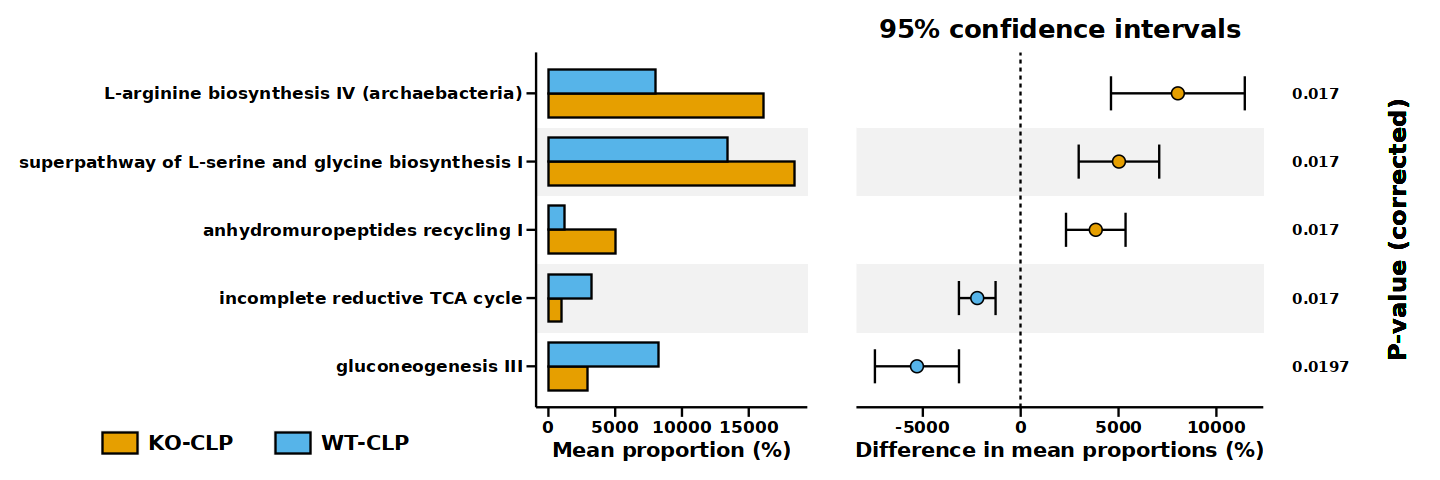

In [239]:
p

In [256]:
outdir = paste(getwd(),"humann_result",sep = "/")
if(dir.exists(outdir)){
  print("dir exists")
}else{
  dir.create(outdir)
}

[1] "dir exists"


In [257]:
ggsave(paste0(outdir,'/',"stamp-KO-CLPvsWT-CLP.pdf"),p,width = 12,height = 4)

In [258]:
write.csv(diff.mean,file = paste0(outdir,'/',"stamp-KO-CLPvsWT-CLP.csv"))

In [240]:
kind = c('g__Akkermansia.s__Akkermansia_muciniphila',
'g__Bacteroides.s__Bacteroides_caecimuris',
'g__Helicobacter.s__Helicobacter_hepaticus',
'g__Acutalibacter.s__Acutalibacter_muris',
'g__Lachnoclostridium.s__Lachnoclostridium_sp. YL32'
)

bad = c('g__Muribaculum.s__Muribaculum_sp. TLL-A4',
'g__Muribaculum.s__Muribaculum_sp. H5',
'g__Muribaculum.s__Muribaculum_intestinale',
'g__Duncaniella.s__Duncaniella_sp. B8',
'g__Lactobacillus.s__Lactobacillus_murinus'
)

In [246]:
humann = read.table("./5.metacyc/humann2_final_out/humann2_pathabundance_cpm_stratified.tsv", header=T, sep="\t")

In [247]:
head(humann)

,Pathway,KO.CLP1_paired_Abundance,KO.CLP2_paired_Abundance,KO.CLP3_paired_Abundance,KO.CLP4_paired_Abundance,KO.CLP5_paired_Abundance,KO.CLP6_paired_Abundance,KO.CLP7_paired_Abundance,KO.CLP8_paired_Abundance,KO.NC1_paired_Abundance,⋯,WT.CLP7_paired_Abundance,WT.CLP8_paired_Abundance,WT.NC1_paired_Abundance,WT.NC2_paired_Abundance,WT.NC3_paired_Abundance,WT.NC4_paired_Abundance,WT.NC5_paired_Abundance,WT.NC6_paired_Abundance,WT.NC7_paired_Abundance,WT.NC8_paired_Abundance
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,UNINTEGRATED|g__Acetatifactor.s__Acetatifactor_muris,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.0000,0.00,0.00,0.00,1573.790,0.00,0.0,0.00,0.00
2,UNINTEGRATED|g__Acutalibacter.s__Acutalibacter_muris,12258.30,1902.6,0.00,0.0,3832.19,3199.64,3788.98,8420.17,2376.47,⋯,3082.63,3455.2800,2841.49,0.00,4096.52,0.000,5061.63,0.0,0.00,2643.67
3,UNINTEGRATED|g__Adlercreutzia.s__Adlercreutzia_equolifaciens,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,⋯,0.00,68.5933,0.00,0.00,0.00,0.000,0.00,0.0,0.00,0.00
4,UNINTEGRATED|g__Akkermansia.s__Akkermansia_muciniphila,148749.00,65341.4,136873.00,21690.4,14989.80,20072.50,13172.80,10423.50,18045.20,⋯,43204.60,40833.3000,5396.52,26488.70,9310.22,950.967,2777.50,16631.1,4168.14,3111.35
5,UNINTEGRATED|g__Anaerotruncus.s__Anaerotruncus_sp_G3_2012,5824.46,5953.5,2870.63,0.0,3552.73,5279.45,6854.57,0.00,0.00,⋯,5576.75,5240.6900,12379.90,7129.53,24142.50,15725.700,19704.20,17304.0,14886.10,13430.80
6,UNINTEGRATED|g__Asaccharobacter.s__Asaccharobacter_celatus,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,⋯,0.00,127.3230,0.00,0.00,0.00,0.000,0.00,0.0,0.00,0.00


In [248]:
humann %>% separate(Pathway, c("pathway", "otu"), "[|]") %>% 
filter(otu %in% c(kind,bad)) -> res

Warning message:
“Expected 2 pieces. Additional pieces discarded in 20 rows [375, 376, 377, 378,
379, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 487, 488, 519,
520].”


In [249]:
res = res[,c(1,2)]

In [254]:
tail(res,2)

,pathway,otu
,<chr>,<chr>
77,VALSYN-PWY: L-valine biosynthesis,g__Akkermansia.s__Akkermansia_muciniphila
78,VALSYN-PWY: L-valine biosynthesis,g__Bacteroides.s__Bacteroides_caecimuris


In [251]:
csv = merge(res,diff.mean,by.x = 'pathway',by.y = 'var')

In [117]:
write.csv(csv,file = paste0(outdir,'/',"pathway-csv.csv"))